/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 2.8603e-04 - val_loss: 0.1156
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 9.5605e-05 - val_loss: 0.0676
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 3.8435e-05 - val_loss: 0.0182
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.2924e-05 - val_loss: 0.0132
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.0812e-05 - val_loss: 0.0151
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.0225e-05 - val_loss: 0.0138
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 1.0769e-05 - val_loss: 0.0141
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 1.0092e-05 - val_loss: 0.0143
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 9.9173e-06 - val_loss: 0.0128
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 9.6095e-06 - val_loss: 0.0123
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 9.5599e-06 - val_loss: 0.0121
Epoch 12/50
19/19 

14:38:19 - cmdstanpy - INFO - Chain [1] start processing
14:38:20 - cmdstanpy - INFO - Chain [1] done processing


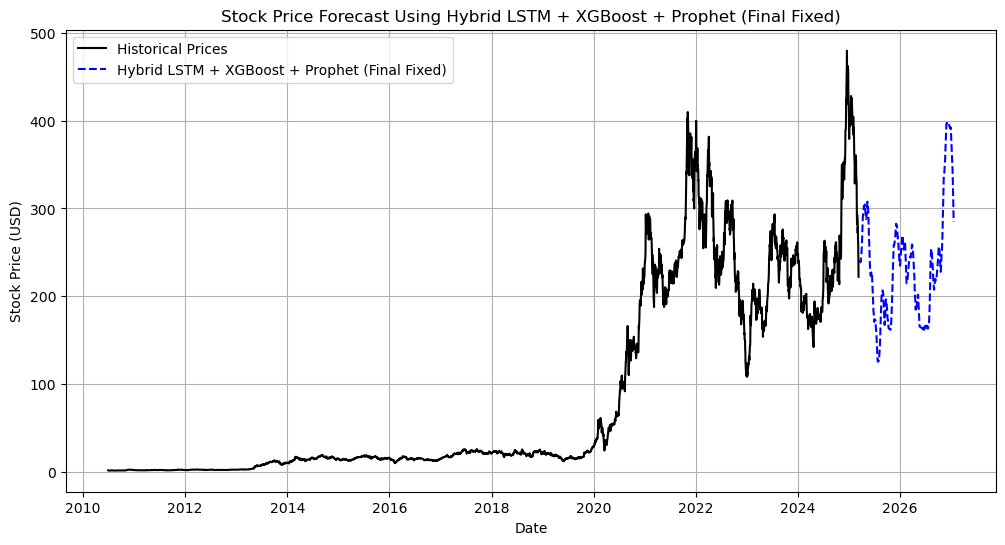

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import BayesianRidge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from xgboost import XGBRegressor
from prophet import Prophet

# 📌 Load and Prepare Data
df = pd.read_csv("/Users/disastershubz/Downloads/MacroTrends_Data_Download_TSLA.csv", skiprows=14)
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# 📌 Normalize Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['close', 'volume']])
df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=['close', 'volume'])

# 📌 Train-Test Split
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled.iloc[:train_size], df_scaled.iloc[train_size:]

# 📌 Function to Create Sequences for LSTM
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data.iloc[i-time_steps:i].values)
        y.append(data['close'].iloc[i])
    return np.array(X), np.array(y)

# 📌 Prepare LSTM Data
time_steps = 60
X_train, y_train = create_sequences(train, time_steps)
X_test, y_test = create_sequences(test, time_steps)
test = test.iloc[time_steps:]  # Align test set

# 📌 LSTM Model (with More Stability)
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),  
    LSTM(64, return_sequences=True),  
    Dropout(0.3),
    LSTM(32),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.0003), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping])
lstm_pred = lstm_model.predict(X_test)

# 📌 XGBoost Model (More Stability)
train_xgb = train[['close', 'volume']]
test_xgb = test[['close', 'volume']]
xgb_model = XGBRegressor(n_estimators=300, max_depth=4, learning_rate=0.02, subsample=0.8)
xgb_model.fit(train_xgb, train['close'])
xgb_pred = xgb_model.predict(test_xgb)

# 📌 Prophet Model (Trend Dampening Applied)
prophet_df = df.reset_index()[['date', 'close']]
prophet_df.columns = ['ds', 'y']
prophet = Prophet(weekly_seasonality=True, changepoint_prior_scale=0.05)  # Lower sensitivity to sudden jumps
prophet.fit(prophet_df)
future_dates = prophet.make_future_dataframe(periods=len(test), freq='D')
prophet_pred = prophet.predict(future_dates)['yhat'].iloc[-len(test):].values

# 📌 Align Predictions (Trim to Minimum Length)
min_len = min(len(lstm_pred), len(xgb_pred), len(prophet_pred))
lstm_pred, xgb_pred, prophet_pred = lstm_pred[:min_len], xgb_pred[:min_len], prophet_pred[:min_len]

# 📌 Rescale Predictions Back to Original Prices
dummy_array = np.zeros((min_len, df_scaled.shape[1]))

dummy_array[:, 0] = lstm_pred.flatten()
lstm_fixed = scaler.inverse_transform(dummy_array)[:, 0]

dummy_array[:, 0] = xgb_pred.flatten()
xgb_fixed = scaler.inverse_transform(dummy_array)[:, 0]

dummy_array[:, 0] = prophet_pred.flatten()
prophet_fixed = scaler.inverse_transform(dummy_array)[:, 0]

# 📌 Weighted Stacking Model (Using Bayesian Ridge Regression)
meta_X = np.column_stack((lstm_fixed, xgb_fixed, prophet_fixed))
meta_y = df['close'].iloc[-min_len:].values

meta_model = BayesianRidge()
meta_model.fit(meta_X, meta_y)
final_pred = meta_model.predict(meta_X)

# 📌 Apply Smoothing to Reduce Volatility
final_pred_smooth = pd.Series(final_pred).rolling(window=10).mean()  # Stronger smoothing

# 📌 Generate Future Dates
future_dates = pd.date_range(start=test.index[-1], periods=len(final_pred_smooth) + 1, freq='D')[1:]

# 📌 Plot Results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["close"], label="Historical Prices", color="black")
plt.plot(future_dates[:len(final_pred_smooth)], final_pred_smooth, label="Hybrid LSTM + XGBoost + Prophet (Final Fixed)", linestyle="dashed", color="blue")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Stock Price Forecast Using Hybrid LSTM + XGBoost + Prophet (Final Fixed)")
plt.legend()
plt.grid(True)
plt.show()
